# Large-scale multi-label text classification

**Author:** [Sayak Paul](https://twitter.com/RisingSayak), [Soumik Rakshit](https://github.com/soumik12345)<br>
**Date created:** 2020/09/25<br>
**Last modified:** 2020/12/23<br>
**Description:** Implementing a large-scale multi-label text classification model.

## Introduction

In this example, we will build a multi-label text classifier to predict the subject areas
of arXiv papers from their abstract bodies. This type of classifier can be useful for
conference submission portals like [OpenReview](https://openreview.net/). Given a paper
abstract, the portal could provide suggestions for which areas the paper would
best belong to.

The dataset was collected using the
[`arXiv` Python library](https://github.com/lukasschwab/arxiv.py)
that provides a wrapper around the
[original arXiv API](http://arxiv.org/help/api/index).
To learn more about the data collection process, please refer to
[this notebook](https://github.com/soumik12345/multi-label-text-classification/blob/master/arxiv_scrape.ipynb).
Additionally, you can also find the dataset on
[Kaggle](https://www.kaggle.com/spsayakpaul/arxiv-paper-abstracts).

## Imports

In [3]:
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

from sklearn.model_selection import train_test_split
from ast import literal_eval

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

## Perform exploratory data analysis

In this section, we first load the dataset into a `pandas` dataframe and then perform
some basic exploratory data analysis (EDA).

In [26]:
arxiv_data = pd.read_csv(
    "https://github.com/soumik12345/multi-label-text-classification/releases/download/v0.2/arxiv_data.csv"
)
arxiv_data.head()
arxiv_data['terms'].iloc[0]

"['cs.CV', 'cs.LG']"

Our text features are present in the `summaries` column and their corresponding labels
are in `terms`. As you can notice, there are multiple categories associated with a
particular entry.

In [25]:
import json


def prepare_json(path: str, out_path: str):
    obj = json.loads(open(path, 'r', encoding='utf-8').read())
    data = []
    for key in obj:
        row = obj[key]
        if row['title'] is not None and row['description'] is not None and row['category'] is not None and row['hierarchy'] is not None:
            if row['title'].strip() != '' and row['description'].strip() != '' and row['category'].strip() != '' and row['hierarchy'].strip() != '':
                row['category'] = str(row['hierarchy'].split('/'))
                
                data.append(obj[key])
    
    df = pd.json_normalize(data)
    df = df.rename(columns={"title": "titles", "category": "terms", 'description': 'summary'})
    df = df[['titles', 'summary', 'terms']]
    df.to_csv(out_path)
    return df

data = prepare_json('./parse/products_data/found.json', './dataset.csv')
data

,titles,summary,terms
0,Нож для яблок Яблокорезка Прибор для удаления ...,Удалитель у яблок предназначен для аккуратного...,"[Дом и сад, Посуда, Кухонные принадлежности, К..."
1,"Набор доктора игровой 2550 ""Волшебная аптечка""...",• В наборе медицинские инструменты (25 предмет...,"[Детские товары, Игрушки и игры, Сюжетно-ролев..."
2,Икона Святитель Николай Чудотворец,"Святитель Николай Мирликийский, или как его ещ...","[Дом и сад, Авторские товары ручной работы, Ик..."
3,"Сухое молоко цельное 1000г, 1 кг",сухое молоко цельное 1 кг,"[Продукты питания, Масла, соусы, специи, Специ..."
4,"Мука ржаная цельнозерновая из био зерна, рожь,...",Рожь для этой муки была выращена без использов...,"[Продукты питания, Макароны, крупы, мука, Мука..."
...,...,...,...
9563,"Комплект кухонный цоколь H-100 мм, длина (2 по...",Цоколь кухонный выполнен из пластика .Цокольна...,"[Мебель, Мебель для кухни, Столешницы и компле..."
9564,Входная дверь Сенатор акация светлая,Входная металлическая дверь для квартиры,"[Строительство и ремонт, Двери, окна и комплек..."
9565,Matrix Total Results Mega Sleek Шампунь профес...,Серия Total Results Mega Sleek это качественна...,"[Красота и здоровье, Уход за волосами, Шампуни..."
9566,Заколка для волос 1 шт.,Стильный и модный бант для волос на заколке-ав...,"[Аксессуары, Детям, Девочкам, Аксессуары для в..."


In [5]:
print(f"There are {len(arxiv_data)} rows in the dataset.")

There are 51774 rows in the dataset.


Real-world data is noisy. One of the most commonly observed source of noise is data
duplication. Here we notice that our initial dataset has got about 13k duplicate entries.

In [6]:
total_duplicate_titles = sum(arxiv_data["titles"].duplicated())
print(f"There are {total_duplicate_titles} duplicate titles.")

There are 12802 duplicate titles.


Before proceeding further, we drop these entries.

In [7]:
arxiv_data = arxiv_data[~arxiv_data["titles"].duplicated()]
print(f"There are {len(arxiv_data)} rows in the deduplicated dataset.")

# There are some terms with occurrence as low as 1.
print(sum(arxiv_data["terms"].value_counts() == 1))

# How many unique terms?
print(arxiv_data["terms"].nunique())

There are 38972 rows in the deduplicated dataset.
2321
3157


As observed above, out of 3,157 unique combinations of `terms`, 2,321 entries have the
lowest occurrence. To prepare our train, validation, and test sets with
[stratification](https://en.wikipedia.org/wiki/Stratified_sampling), we need to drop
these terms.

In [8]:
# Filtering the rare terms.
arxiv_data_filtered = arxiv_data.groupby("terms").filter(lambda x: len(x) > 1)
arxiv_data_filtered.shape

(36651, 3)

## Convert the string labels to lists of strings

The initial labels are represented as raw strings. Here we make them `List[str]` for a
more compact representation.

In [9]:
arxiv_data_filtered["terms"] = arxiv_data_filtered["terms"].apply(
    lambda x: literal_eval(x)
)
arxiv_data_filtered["terms"].values[:5]

array([list(['cs.CV', 'cs.LG']), list(['cs.CV', 'cs.AI', 'cs.LG']),
       list(['cs.CV', 'cs.AI']), list(['cs.CV']),
       list(['cs.CV', 'cs.LG'])], dtype=object)

## Use stratified splits because of class imbalance

The dataset has a
[class imbalance problem](https://developers.google.com/machine-learning/glossary/#class-imbalanced-dataset).
So, to have a fair evaluation result, we need to ensure the datasets are sampled with
stratification. To know more about different strategies to deal with the class imbalance
problem, you can follow
[this tutorial](https://www.tensorflow.org/tutorials/structured_data/imbalanced_data).
For an end-to-end demonstration of classification with imbablanced data, refer to
[Imbalanced classification: credit card fraud detection](https://keras.io/examples/structured_data/imbalanced_classification/).

In [10]:
test_split = 0.1

# Initial train and test split.
train_df, test_df = train_test_split(
    arxiv_data_filtered,
    test_size=test_split,
    stratify=arxiv_data_filtered["terms"].values,
)

# Splitting the test set further into validation
# and new test sets.
val_df = test_df.sample(frac=0.5)
test_df.drop(val_df.index, inplace=True)

print(f"Number of rows in training set: {len(train_df)}")
print(f"Number of rows in validation set: {len(val_df)}")
print(f"Number of rows in test set: {len(test_df)}")

Number of rows in training set: 32985
Number of rows in validation set: 1833
Number of rows in test set: 1833


## Multi-label binarization

Now we preprocess our labels using the
[`StringLookup`](https://keras.io/api/layers/preprocessing_layers/categorical/string_lookup)
layer.

In [11]:
terms = tf.ragged.constant(train_df["terms"].values)
lookup = tf.keras.layers.StringLookup(output_mode="multi_hot")
lookup.adapt(terms)
vocab = lookup.get_vocabulary()


def invert_multi_hot(encoded_labels):
    """Reverse a single multi-hot encoded label to a tuple of vocab terms."""
    hot_indices = np.argwhere(encoded_labels == 1.0)[..., 0]
    return np.take(vocab, hot_indices)


print("Vocabulary:\n")
print(vocab)


Vocabulary:

['[UNK]', 'cs.CV', 'cs.LG', 'stat.ML', 'cs.AI', 'eess.IV', 'cs.RO', 'cs.CL', 'cs.NE', 'cs.CR', 'math.OC', 'eess.SP', 'cs.GR', 'cs.SI', 'cs.MM', 'cs.SY', 'cs.IR', 'cs.MA', 'eess.SY', 'cs.HC', 'math.IT', 'cs.IT', 'cs.DC', 'cs.CY', 'stat.AP', 'stat.TH', 'math.ST', 'stat.ME', 'eess.AS', 'cs.SD', 'q-bio.QM', 'q-bio.NC', 'cs.DS', 'cs.GT', 'cs.CG', 'cs.NI', 'cs.SE', 'I.2.6', 'stat.CO', 'math.NA', 'cs.NA', 'physics.chem-ph', 'cs.DB', 'q-bio.BM', 'cs.LO', 'cond-mat.dis-nn', '68T45', 'math.PR', 'cs.PL', 'physics.comp-ph', 'cs.CE', 'cs.AR', 'I.2.10', 'q-fin.ST', 'cond-mat.stat-mech', 'math.DS', '68T05', 'quant-ph', 'physics.data-an', 'cs.CC', 'I.4.6', 'physics.soc-ph', 'physics.ao-ph', 'cs.DM', 'econ.EM', 'q-bio.GN', 'physics.med-ph', 'cs.PF', 'astro-ph.IM', 'I.4.8', 'math.AT', 'cs.FL', 'I.4', 'q-fin.TR', 'I.5.4', 'I.2', '68U10', 'physics.optics', 'physics.geo-ph', 'hep-ex', '68T10', 'cond-mat.mtrl-sci', 'physics.flu-dyn', 'math.AP', 'I.4; I.5', 'I.4.9', 'I.2.6; I.2.8', 'I.2.10; I.4;

Here we are separating the individual unique classes available from the label
pool and then using this information to represent a given label set with 0's and 1's.
Below is an example.

In [12]:
sample_label = train_df["terms"].iloc[0]
print(f"Original label: {sample_label}")

label_binarized = lookup([sample_label])
print(f"Label-binarized representation: {label_binarized}")

Original label: ['cs.LG', 'cs.CV']
Label-binarized representation: [[0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0.]]


## Data preprocessing and `tf.data.Dataset` objects

We first get percentile estimates of the sequence lengths. The purpose will be clear in a
moment.

In [13]:
train_df["summaries"].apply(lambda x: len(x.split(" "))).describe()

count    32985.000000
mean       156.478672
std         41.485940
min          5.000000
25%        128.000000
50%        154.000000
75%        183.000000
max        462.000000
Name: summaries, dtype: float64

Notice that 50% of the abstracts have a length of 154 (you may get a different number
based on the split). So, any number close to that value is a good enough approximate for the
maximum sequence length.

Now, we implement utilities to prepare our datasets.

In [14]:
max_seqlen = 150
batch_size = 128
padding_token = "<pad>"
auto = tf.data.AUTOTUNE


def make_dataset(dataframe, is_train=True):
    labels = tf.ragged.constant(dataframe["terms"].values)
    label_binarized = lookup(labels).numpy()
    dataset = tf.data.Dataset.from_tensor_slices(
        (dataframe["summaries"].values, label_binarized)
    )
    dataset = dataset.shuffle(batch_size * 10) if is_train else dataset
    return dataset.batch(batch_size)


Now we can prepare the `tf.data.Dataset` objects.

In [15]:
train_dataset = make_dataset(train_df, is_train=True)
validation_dataset = make_dataset(val_df, is_train=False)
test_dataset = make_dataset(test_df, is_train=False)

## Dataset preview

In [16]:
text_batch, label_batch = next(iter(train_dataset))

for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Abstract: {text}")
    print(f"Label(s): {invert_multi_hot(label[0])}")
    print(" ")

Abstract: b'We propose Pixel-BERT to align image pixels with text by deep multi-modal\ntransformers that jointly learn visual and language embedding in a unified\nend-to-end framework. We aim to build a more accurate and thorough connection\nbetween image pixels and language semantics directly from image and sentence\npairs instead of using region-based image features as the most recent vision\nand language tasks. Our Pixel-BERT which aligns semantic connection in pixel\nand text level solves the limitation of task-specific visual representation for\nvision and language tasks. It also relieves the cost of bounding box\nannotations and overcomes the unbalance between semantic labels in visual task\nand language semantic. To provide a better representation for down-stream\ntasks, we pre-train a universal end-to-end model with image and sentence pairs\nfrom Visual Genome dataset and MS-COCO dataset. We propose to use a random\npixel sampling mechanism to enhance the robustness of visual r

## Vectorization

Before we feed the data to our model, we need to vectorize it (represent it in a numerical form).
For that purpose, we will use the
[`TextVectorization` layer](https://keras.io/api/layers/preprocessing_layers/text/text_vectorization).
It can operate as a part of your main model so that the model is excluded from the core
preprocessing logic. This greatly reduces the chances of training / serving skew during inference.

We first calculate the number of unique words present in the abstracts.

In [17]:
# Source: https://stackoverflow.com/a/18937309/7636462
vocabulary = set()
train_df["summaries"].str.lower().str.split().apply(vocabulary.update)
vocabulary_size = len(vocabulary)
print(vocabulary_size)


153450


We now create our vectorization layer and `map()` to the `tf.data.Dataset`s created
earlier.

In [18]:
text_vectorizer = layers.TextVectorization(
    max_tokens=vocabulary_size, ngrams=2, output_mode="tf_idf"
)

# `TextVectorization` layer needs to be adapted as per the vocabulary from our
# training set.
with tf.device("/CPU:0"):
    text_vectorizer.adapt(train_dataset.map(lambda text, label: text))

train_dataset = train_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)
validation_dataset = validation_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)
test_dataset = test_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)


A batch of raw text will first go through the `TextVectorization` layer and it will
generate their integer representations. Internally, the `TextVectorization` layer will
first create bi-grams out of the sequences and then represent them using
[TF-IDF](https://wikipedia.org/wiki/Tf%E2%80%93idf). The output representations will then
be passed to the shallow model responsible for text classification.

To learn more about other possible configurations with `TextVectorizer`, please consult
the
[official documentation](https://keras.io/api/layers/preprocessing_layers/text/text_vectorization).

**Note**: Setting the `max_tokens` argument to a pre-calculated vocabulary size is
not a requirement.

## Create a text classification model

We will keep our model simple -- it will be a small stack of fully-connected layers with
ReLU as the non-linearity.

In [19]:

def make_model():
    shallow_mlp_model = keras.Sequential(
        [
            layers.Dense(512, activation="relu"),
            layers.Dense(256, activation="relu"),
            layers.Dense(lookup.vocabulary_size(), activation="sigmoid"),
        ]  # More on why "sigmoid" has been used here in a moment.
    )
    return shallow_mlp_model


## Train the model

We will train our model using the binary crossentropy loss. This is because the labels
are not disjoint. For a given abstract, we may have multiple categories. So, we will
divide the prediction task into a series of multiple binary classification problems. This
is also why we kept the activation function of the classification layer in our model to
sigmoid. Researchers have used other combinations of loss function and activation
function as well. For example, in
[Exploring the Limits of Weakly Supervised Pretraining](https://arxiv.org/abs/1805.00932),
Mahajan et al. used the softmax activation function and cross-entropy loss to train
their models.

Epoch 1/5
258/258 [==============================] - 165s 620ms/step - loss: 0.0309 - categorical_accuracy: 0.8501 - val_loss: 0.0193 - val_categorical_accuracy: 0.9023
Epoch 2/5
258/258 [==============================] - 145s 562ms/step - loss: 0.0029 - categorical_accuracy: 0.8780 - val_loss: 0.0271 - val_categorical_accuracy: 0.8838
Epoch 3/5
258/258 [==============================] - 135s 524ms/step - loss: 8.6010e-04 - categorical_accuracy: 0.8408 - val_loss: 0.0334 - val_categorical_accuracy: 0.8554
Epoch 4/5
258/258 [==============================] - 105s 406ms/step - loss: 4.3054e-04 - categorical_accuracy: 0.8403 - val_loss: 0.0386 - val_categorical_accuracy: 0.8505
Epoch 5/5
258/258 [==============================] - 99s 385ms/step - loss: 2.6534e-04 - categorical_accuracy: 0.8113 - val_loss: 0.0430 - val_categorical_accuracy: 0.8472


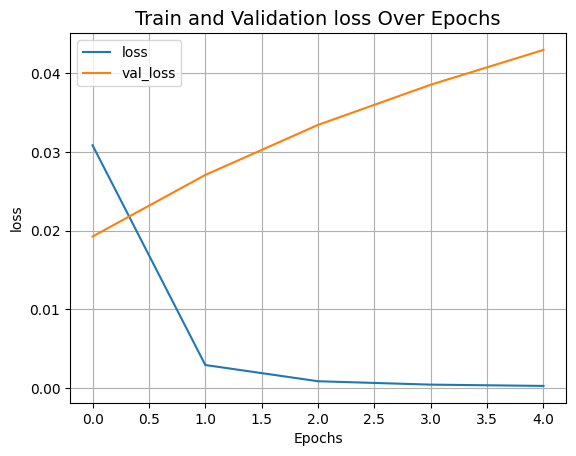

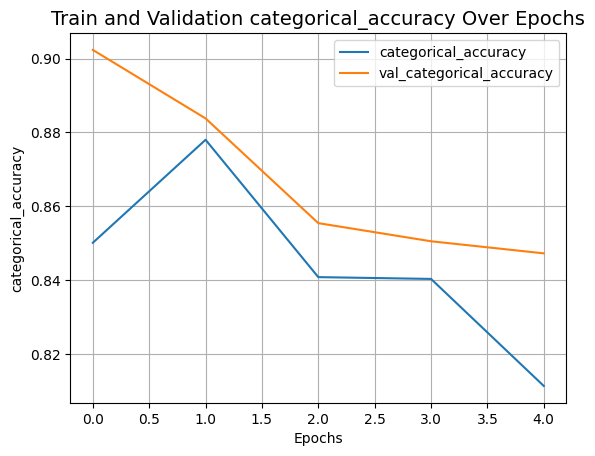

In [21]:
epochs = 5

shallow_mlp_model = make_model()
shallow_mlp_model.compile(
    loss="binary_crossentropy", optimizer="adam", metrics=["categorical_accuracy"]
)

history = shallow_mlp_model.fit(
    train_dataset, validation_data=validation_dataset, epochs=epochs
)


def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("categorical_accuracy")

While training, we notice an initial sharp fall in the loss followed by a gradual decay.

### Evaluate the model

In [22]:
_, categorical_acc = shallow_mlp_model.evaluate(test_dataset)
print(f"Categorical accuracy on the test set: {round(categorical_acc * 100, 2)}%.")

15/15 [==============================] - 2s 152ms/step - loss: 0.0426 - categorical_accuracy: 0.8396
Categorical accuracy on the test set: 83.96%.


The trained model gives us an evaluation accuracy of ~87%.

## Inference

An important feature of the
[preprocessing layers provided by Keras](https://keras.io/guides/preprocessing_layers/)
is that they can be included inside a `tf.keras.Model`. We will export an inference model
by including the `text_vectorization` layer on top of `shallow_mlp_model`. This will
allow our inference model to directly operate on raw strings.

**Note** that during training it is always preferable to use these preprocessing
layers as a part of the data input pipeline rather than the model to avoid
surfacing bottlenecks for the hardware accelerators. This also allows for
asynchronous data processing.

In [23]:
# Create a model for inference.
model_for_inference = keras.Sequential([text_vectorizer, shallow_mlp_model])

# Create a small dataset just for demoing inference.
inference_dataset = make_dataset(test_df.sample(100), is_train=False)
text_batch, label_batch = next(iter(inference_dataset))
predicted_probabilities = model_for_inference.predict(text_batch)

# Perform inference.
for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Abstract: {text}")
    print(f"Label(s): {invert_multi_hot(label[0])}")
    predicted_proba = [proba for proba in predicted_probabilities[i]]
    top_3_labels = [
        x
        for _, x in sorted(
            zip(predicted_probabilities[i], lookup.get_vocabulary()),
            key=lambda pair: pair[0],
            reverse=True,
        )
    ][:3]
    print(f"Predicted Label(s): ({', '.join([label for label in top_3_labels])})")
    print(" ")

4/4 [==============================] - 0s 45ms/step
Abstract: b'Group fairness definitions such as Demographic Parity and Equal Opportunity\nmake assumptions about the underlying decision-problem that restrict them to\nclassification problems. Prior work has translated these definitions to other\nmachine learning environments, such as unsupervised learning and reinforcement\nlearning, by implementing their closest mathematical equivalent. As a result,\nthere are numerous bespoke interpretations of these definitions. Instead, we\nprovide a generalized set of group fairness definitions that unambiguously\nextend to all machine learning environments while still retaining their\noriginal fairness notions. We derive two fairness principles that enable such a\ngeneralized framework. First, our framework measures outcomes in terms of\nutilities, rather than predictions, and does so for both the decision-algorithm\nand the individual. Second, our framework considers counterfactual outcomes,\nr

The prediction results are not that great but not below the par for a simple model like
ours. We can improve this performance with models that consider word order like LSTM or
even those that use Transformers ([Vaswani et al.](https://arxiv.org/abs/1706.03762)).

## Acknowledgements

We would like to thank [Matt Watson](https://github.com/mattdangerw) for helping us
tackle the multi-label binarization part and inverse-transforming the processed labels
to the original form.